In [1]:
from significance_of_mean_cuda import significance_of_mean_cuda
from utils import significance_of_mean, getdf, my_scatter_plot
import numpy as np
import time
import multiprocessing
import concurrent.futures as cf
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from IPython.display import Image

import time
from scipy.stats import ttest_ind, ttest_rel, chisquare, ks_2samp
import pandas as pd
import seaborn as sns

import matplotlib as mpl

mpl.rcParams['text.usetex'] = False  # not really needed

from scipy import stats

### Load data from MC approximation of permutation test

In [2]:
def loadMcResult(sampleShape, mean):
    X_list = list()
    y_list = list()
    p_val_list = list()
    time_listMc = list()
    for S in sampleShape:
        X = pd.read_csv("dataFastPerm/data_{}/X_{}.csv".format(mean, S))
        Y = pd.read_csv("dataFastPerm/data_{}/y_{}.csv".format(mean, S))
        p_val = pd.read_csv("dataFastPerm/data_{}/error_{}.csv".format(mean, S))
        timeMc = pd.read_csv("dataFastPerm/data_{}/Time_{}.csv".format(mean, S))
    
    
        X.columns = range(X.shape[1])
        Y.columns = range(Y.shape[1])
        p_val.columns = range(p_val.shape[1])
        timeMc.columns = range(timeMc.shape[1])
    
    
        X_list.append([np.array(x.split(" ")[1:]).astype(float) for x in X[0].values])
        y_list.append([np.array(y.split(" ")[1:]).astype(float) for y in Y[0].values])
        p_val_list.append(np.array([float(p[0].split(" ")[1]) for p in p_val.values]))
        time_listMc.append([float(t[0].split(" ")[1]) for t in timeMc.values])
    
    return X_list, y_list, p_val_list, time_listMc

### Get p-value for the the parallelized permutation test

In [3]:
def run_test(X,Y,bins):

    #Exact test
    SGM = significance_of_mean_cuda(bins, dtype_v=np.uint32,dtype_A=np.float64)
    SGM.run(X.reshape(1,-1),Y.reshape(1,-1))

        
    return SGM.p_values[0]

### Get all p-values from the prallelized exact test from the same data as the MC version

In [4]:
def getParallelizedResult(X_list, y_list, bins):
    pt_list = list()
    pe_list = list()
    TIME = list()

    for Xp, yp in zip(X_list, y_list):
        Xp = np.asarray(Xp).T
        yp = np.asarray(yp).T
        
        p_t = list()
        p_e = list()
        time_list = list()
    
        for x, y in zip(Xp, yp):
            p_t.append(ttest_ind(y, x)[1] / 2)
        
            start = time.time()
            p_e.append(run_test(y, x, bins))
            end = time.time()
        
            time_list.append(end - start)
    
        pt_list.append(p_t)
        pe_list.append(p_e)
        TIME.append(time_list)
    
    return pt_list, pe_list, TIME
    

### Compare parallelized and MC version

In [5]:
def compare(p_val_list, pe_list, pt_list):
    PE_err = list()
    PAE_err = list()
    
    for P_ae, P_e, P_t in zip(p_val_list, pe_list, pt_list):
        P_ae_error = list()
        P_e_error = list()
        
        for ae, e, t in zip(P_ae, P_e, P_t):
            P_ae_error.append((ae - t) / t)
            P_e_error.append((e - t) / t)
            
        PE_err.append(P_e_error)
        PAE_err.append(P_ae_error)
    
    return PE_err, PAE_err


### Boxplot

In [6]:
def boxPlot(error, Bin, error_type="abs",path=None):
    my_dict = dict()
    for d, b in zip(error, Bin):
        my_dict[str(b)] = d
    
    fig, ax = plt.subplots()
    ax.boxplot(my_dict.values())
    ax.set_xticklabels(my_dict.keys())
    
    plt.ylabel(r"$\frac{p_{e}-p_{t}}{p_{t}}$",fontsize=20)
        
    plt.xlabel("Sample size",fontsize=15)
    
    
    
    if path:
        fig.savefig(path+ str(i)+".jpg", bbox_inches='tight')
        
    

### Time-plot

In [7]:
def timePlot(TIMEParallel, TIME_MC, sampleShape):
    plt.plot(sampleShape, np.mean(TIMEParallel,axis=1), 'r-', label='Parallelization of P-value')
    plt.plot(sampleShape, np.mean(TIME_MC,axis=1), 'g-', label='Approximation of P-value')
    plt.legend(loc='upper left')
    plt.xlabel(r"Sample size")
    plt.ylabel("Time(s)")
    plt.tight_layout()
    plt.savefig("figures/normal_S")
    plt.show()

## Sample sizes of X and Y

In [8]:
sampleShape = [10,50,100,150,200,250,300]

# Experiment 1: with $X \sim N(5.0,1)$ and $Y\sim N(5.2,1)$

In [9]:
X_list, y_list, p_val_list, time_listMc = loadMcResult(sampleShape, 5.2)

In [10]:
pt_list, pe_list, TIME = getParallelizedResult(np.asarray(X_list), np.asarray(y_list), 40)

In [11]:
PE_err, PAE_err = compare(p_val_list, pe_list, pt_list)

## Approximation of P-value

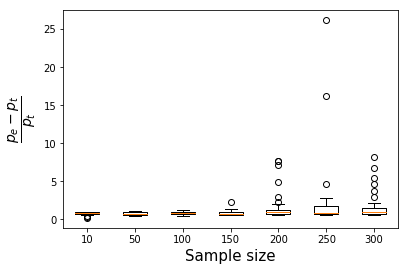

In [12]:
boxPlot(PAE_err, sampleShape)

## Parallelization of P-value

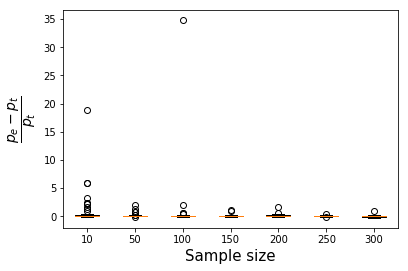

In [13]:
boxPlot(PE_err, sampleShape)

In [14]:
TIMEParallel = np.asarray([np.array(T) for T in TIME])
TIME_MC = np.asarray([np.array(Tmc) for Tmc in time_listMc])

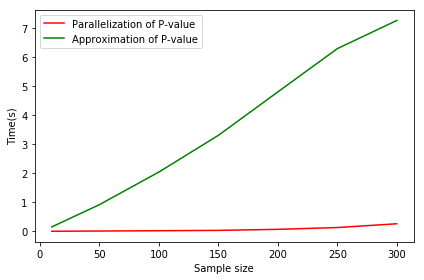

In [15]:
timePlot(TIMEParallel, TIME_MC, sampleShape)

# Experiment 2: with $X \sim N(5.0,1)$ and $Y\sim N(5.4,1)$

In [16]:
X_list, y_list, p_val_list, time_listMc = loadMcResult(sampleShape, 5.4)
pt_list, pe_list, TIME = getParallelizedResult(np.asarray(X_list), np.asarray(y_list), 40)
PE_err, PAE_err = compare(p_val_list, pe_list, pt_list)

## Approximation of P-value

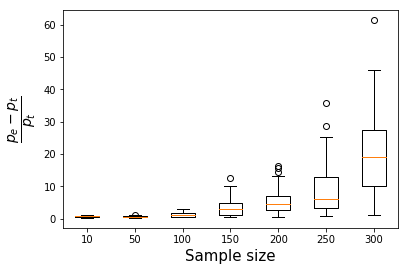

In [17]:
boxPlot(PAE_err, sampleShape)

## Parallelization of P-value

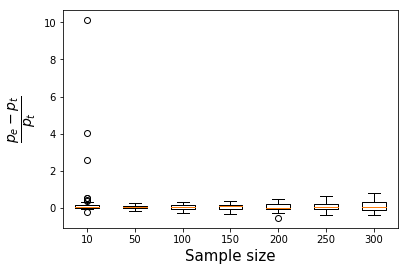

In [18]:
boxPlot(PE_err, sampleShape)

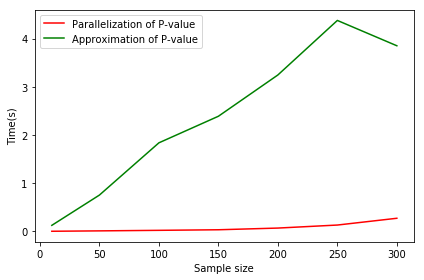

In [19]:
TIMEParallel = np.asarray([np.array(T) for T in TIME])
TIME_MC = np.asarray([np.array(Tmc) for Tmc in time_listMc])
timePlot(TIMEParallel, TIME_MC, sampleShape)

# Experiment 3: with $X \sim N(5.0,1)$ and $Y\sim N(5.6,1)$

In [20]:
X_list, y_list, p_val_list, time_listMc = loadMcResult(sampleShape, 5.6)
pt_list, pe_list, TIME = getParallelizedResult(np.asarray(X_list), np.asarray(y_list), 40)
PE_err, PAE_err = compare(p_val_list, pe_list, pt_list)

## Approximation of P-value

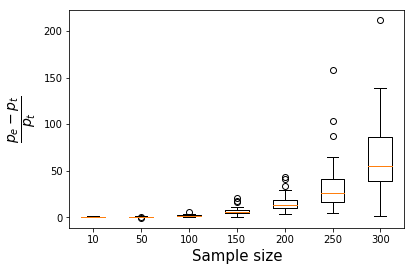

In [21]:
boxPlot(PAE_err, sampleShape)

## Parallelization of P-value

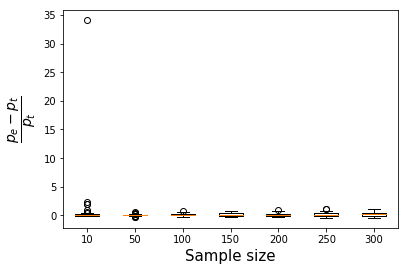

In [22]:
boxPlot(PE_err, sampleShape)

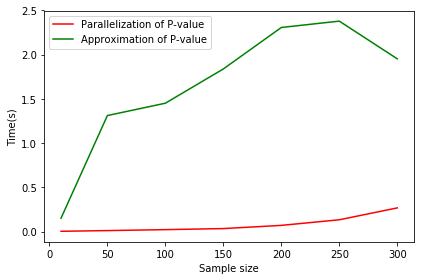

In [23]:
TIMEParallel = np.asarray([np.array(T) for T in TIME])
TIME_MC = np.asarray([np.array(Tmc) for Tmc in time_listMc])
timePlot(TIMEParallel, TIME_MC, sampleShape)

# Experiment 4: with $X \sim N(5.0,1)$ and $Y\sim N(5.8,1)$

In [24]:
X_list, y_list, p_val_list, time_listMc = loadMcResult(sampleShape, 5.8)
pt_list, pe_list, TIME = getParallelizedResult(np.asarray(X_list), np.asarray(y_list), 40)
PE_err, PAE_err = compare(p_val_list, pe_list, pt_list)

## Approximation of P-value

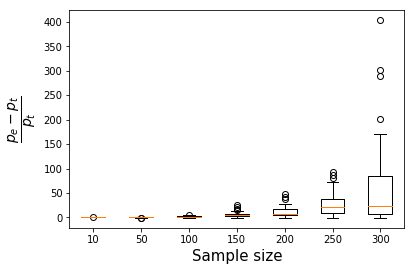

In [25]:
boxPlot(PAE_err, sampleShape)

## Parallelization of P-value

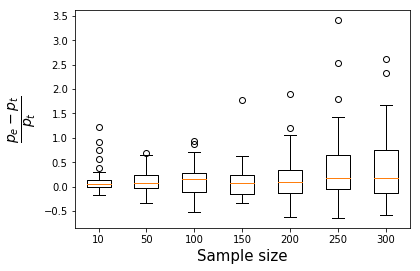

In [26]:
boxPlot(PE_err, sampleShape)

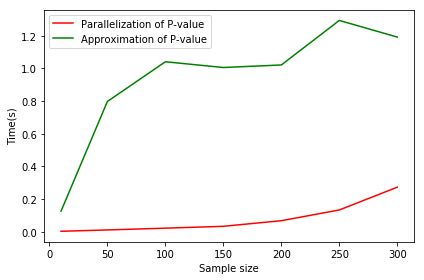

In [27]:
TIMEParallel = np.asarray([np.array(T) for T in TIME])
TIME_MC = np.asarray([np.array(Tmc) for Tmc in time_listMc])
timePlot(TIMEParallel, TIME_MC, sampleShape)

# Experiment 5: with $X \sim N(5.0,1)$ and $Y\sim N(6.0,1)$

In [28]:
X_list, y_list, p_val_list, time_listMc = loadMcResult(sampleShape, 6)
pt_list, pe_list, TIME = getParallelizedResult(np.asarray(X_list), np.asarray(y_list), 40)
PE_err, PAE_err = compare(p_val_list, pe_list, pt_list)

## Approximation of P-value

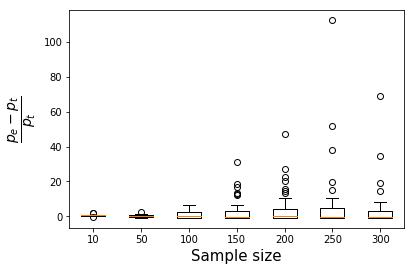

In [29]:
boxPlot(PAE_err, sampleShape)

## Parallelization of P-value

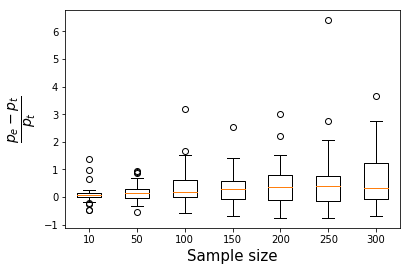

In [30]:
boxPlot(PE_err, sampleShape)

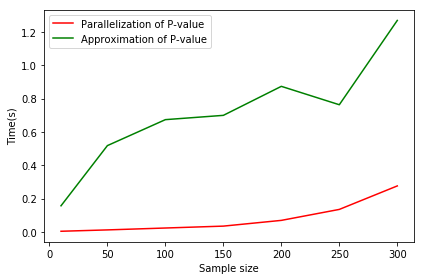

In [31]:
TIMEParallel = np.asarray([np.array(T) for T in TIME])
TIME_MC = np.asarray([np.array(Tmc) for Tmc in time_listMc])
timePlot(TIMEParallel, TIME_MC, sampleShape)